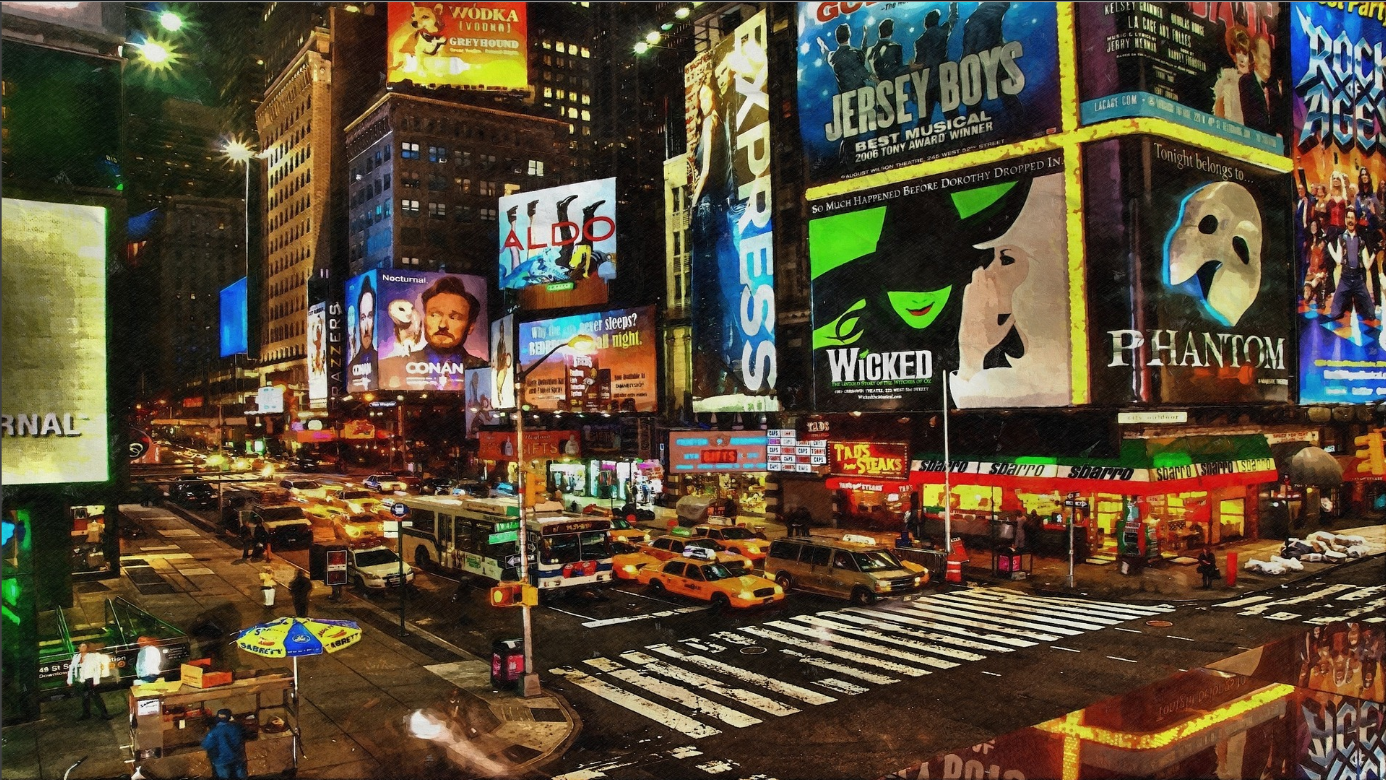

# Milestone 3- SageMaker ML Pipeline Creation:

Business Context: 

Fashion Haven has recognized the importance of data-driven decision-making and has successfully developed a predictive model for sales revenue estimation based on their advertising campaigns across different media sources (TV, Newspaper, Radio). To scale their efforts and make data-driven decisions more accessible throughout the organization, Fashion Haven aims to create an automated machine-learning pipeline for sales revenue prediction.

The goal of this assignment is to design and implement a machine-learning pipeline that automates the entire process of data preprocessing, model training, and evaluation. The automated pipeline should take in raw data containing information on advertising campaigns and sales revenue across various stores and media sources. It should then transform the data, select the most relevant features, train the model, and evaluate its performance.

By creating an automated machine-learning pipeline, Fashion Haven aims to streamline the process of sales revenue prediction, making it accessible to various departments within the organization. This automation will save time and effort for data scientists and other stakeholders, allowing them to focus on higher-value tasks and strategic decision-making.

### Setup

**General Imports**

In [2]:
import logging
import json

* "import logging" is used to import the logging module in Python, which provides a set of functions and classes for generating log messages. This module allows to record and store informative messages, warnings, errors, and other events during the execution of a program.

* Similarly, the line "import json" is used to import the json module in Python. The json module provides functions for working with JSON (JavaScript Object Notation) data, including parsing JSON strings, encoding Python objects into JSON, and decoding JSON back into Python objects. It enables easy manipulation and handling of data in the JSON format within a Python program.

**SageMaker Imports**

In [3]:
import sagemaker

from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import ProcessingStep, TrainingStep
from sagemaker.workflow.properties import PropertyFile

from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.processing import ScriptProcessor

from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.sklearn.estimator import SKLearn

from sagemaker.inputs import TrainingInput

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


* import sagemaker: This imports the core sagemaker module, which provides functionality for working with SageMaker services.

* from sagemaker.workflow.pipeline import Pipeline: This imports the Pipeline class from the sagemaker.workflow.pipeline module. It allows to create and manage machine learning pipelines in SageMaker.

* from sagemaker.workflow.steps import ProcessingStep, TrainingStep: This imports the ProcessingStep and TrainingStep classes from the sagemaker.workflow.steps module. These classes represent individual steps in a machine learning pipeline, such as data processing and model training.

* from sagemaker.workflow.properties import PropertyFile: This imports the PropertyFile class from the sagemaker.workflow.properties module. It allows to define and reference property files within a pipeline.

* from sagemaker.processing import ProcessingInput, ProcessingOutput: This imports the ProcessingInput and ProcessingOutput classes from the sagemaker.processing module. These classes represent input and output data for processing jobs in SageMaker.

* from sagemaker.processing import ScriptProcessor: This imports the ScriptProcessor class from the sagemaker.processing module. It enables running script-based processing jobs using custom Docker containers.

* from sagemaker.sklearn.processing import SKLearnProcessor: This imports the SKLearnProcessor class from the sagemaker.sklearn.processing module. It provides functionality for running scikit-learn-based processing jobs in SageMaker.

* from sagemaker.sklearn.estimator import SKLearn: This imports the SKLearn class from the sagemaker.sklearn.estimator module. It allows to create an estimator for scikit-learn-based training jobs in SageMaker.

* from sagemaker.inputs import TrainingInput: This imports the TrainingInput class from the sagemaker.inputs module. It represents the input data for a training job in SageMaker.

**SageMaker Authentication**

In [4]:
pipeline_session = sagemaker.Session(
    default_bucket="milestone-three"
)

* The above code creates an instance of the sagemaker.Session class and assigns it to the variable pipeline_session. The sagemaker.Session class represents a session with the SageMaker service and provides methods for working with SageMaker resources.

* The default_bucket parameter is set to "milestone-three". This specifies the default Amazon S3 bucket to be used by the SageMaker session. Amazon S3 is a storage service provided by Amazon Web Services (AWS) that is commonly used for storing data and artifacts related to machine learning projects in SageMaker.

* By setting the default_bucket parameter, the sagemaker.Session instance will automatically use this specific S3 bucket for storing and retrieving data during the pipeline execution, unless explicitly specified otherwise.

In [5]:
try:
    aws_role = sagemaker.get_execution_role()
except ValueError:
    print('Local configuration is not complete; use SageMaker Studio')

* The above code attempts to retrieve the AWS execution role using the sagemaker.get_execution_role() function.

* The get_execution_role() function is commonly used in SageMaker to obtain the IAM role assigned to the notebook instance or execution environment. This role provides permissions to access AWS services and resources.

* In the code, it is wrapped in a try-except block. If the get_execution_role() function raises a ValueError, it means that the local configuration is not complete, indicating that the code is not running in a SageMaker Studio environment.

In [6]:
print(f"AWS execution role associated with the account {aws_role}")
print(f"Default bucket associated with the account: {pipeline_session.default_bucket()}")
print(f"Default boto region associated with the account: {pipeline_session.boto_region_name}")

AWS execution role associated with the account arn:aws:iam::784220232897:role/service-role/AmazonSageMaker-ExecutionRole-20241109T090183
Default bucket associated with the account: milestone-three
Default boto region associated with the account: us-east-2


### SageMaker Pipelines

#### Step 1: Preprocessing

In [7]:
input_data_uri = 's3://milestone-three/marketing3.csv'

In [8]:
sklearn_processor = SKLearnProcessor(
    framework_version="1.0-1",
    instance_type="ml.m4.xlarge",
    instance_count=1,
    base_job_name="sklearn-marketing-process1",
    role=aws_role,
    sagemaker_session=pipeline_session
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


* The above code creates an instance of the SKLearnProcessor class from the sagemaker.sklearn.processing module and assigns it to the variable sklearn_processor. This processor is used for running scikit-learn-based processing jobs in SageMaker.

* Here's an explanation of the parameters used in the SKLearnProcessor constructor:

* framework_version: Specifies the version of scikit-learn to be used in the processing job. In this case, it is set to "1.0-1".

* instance_type: Specifies the type of SageMaker instance to be used for the processing job. The "ml.m4.xlarge" instance type is chosen here.

* instance_count: Specifies the number of instances to be used for the processing job. In this case, a single instance is used.

* base_job_name: Specifies the base name for the processing job. It helps identify and organize the job resources in SageMaker.

* role: Specifies the AWS execution role used by the processing job. The aws_role variable, which should contain the execution role, is provided here.

* sagemaker_session: Specifies the SageMaker session to be used by the processor. The pipeline_session variable, which represents a session configured with a default S3 bucket, is provided here.

* By creating an instance of SKLearnProcessor with these parameters, we can use it to run scikit-learn-based processing jobs in SageMaker, leveraging the specified configuration and resources.

In [9]:
step_process = ProcessingStep(
    name="marketingProcess1",
    processor=sklearn_processor,
    inputs=[
      ProcessingInput(source=input_data_uri, destination="/opt/ml/processing/input"),  
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test")
    ],
    code="transform.py",
)

* The above code creates a new instance of the ProcessingStep class and assigns it to the variable step_process. This step represents a processing job in a machine learning pipeline using SageMaker.

* The name parameter is set to "marketingProcess1", providing a descriptive name for the processing step.

* The processor parameter is set to sklearn_processor, which is an instance of the SKLearnProcessor class previously created. It specifies the processor to be used for the processing step, which in this case is the scikit-learn processor.

* The inputs parameter is a list that specifies the input data for the processing step. In this case, there is a single input specified using the ProcessingInput class. The source parameter represents the source location of the input data, and the destination parameter is set to "/opt/ml/processing/input" within the processing container.

* The outputs parameter is a list that specifies the output data for the processing step. Two outputs are defined using the ProcessingOutput class. The output_name parameter is set to "train" and "test" to label the respective outputs. The source parameter specifies the source directories within the processing container, which are set to "/opt/ml/processing/train" and "/opt/ml/processing/test".

* The code parameter specifies the script file to be executed for the processing step. In this case, "transform.py" is provided, which represents the script that will be executed using the specified processor.

* By creating an instance of ProcessingStep with these parameters, we include a processing job in our machine learning pipeline. The job will use the specified processor, input data location, output locations, and script file to perform the required processing tasks.

In [10]:
step_process.inputs

In [11]:
step_process.outputs

#### Step 2: Training

In [12]:
sklearn_estimator = SKLearn(
    entry_point="dt.py",
    framework_version="1.0-1",
    role=aws_role,
    sagemaker_session=pipeline_session,
    instance_type="ml.m4.xlarge",
    instance_count=1,
    volume_size=1
)

* The above code creates an instance of the SKLearn class from the sagemaker.sklearn.estimator module and assigns it to the variable sklearn_estimator. This estimator is used for creating scikit-learn-based training jobs in SageMaker.

* Here's an explanation of the parameters used in the SKLearn constructor:

* entry_point: Specifies the entry point script for the training job. In this case, "dt.py" is provided, representing the script that will be executed during training.

* framework_version: Specifies the version of scikit-learn to be used in the training job. In this case, it is set to "1.0-1".

* role: Specifies the AWS execution role used by the training job. The aws_role variable, which should contain the execution role, is provided here.

* sagemaker_session: Specifies the SageMaker session to be used by the estimator. The pipeline_session variable, which represents a session configured with a default S3 bucket, is provided here.

* instance_type: Specifies the type of SageMaker instance to be used for the training job. In this case, "ml.m4.xlarge" instance type is chosen.

* instance_count: Specifies the number of instances to be used for the training job. In this case, a single instance is used.

* volume_size: Specifies the size of the Amazon EBS (Elastic Block Store) volume, in GB, to be attached to each training instance. In this case, a volume size of 1 GB is set.

* By creating an instance of SKLearn with these parameters, we can use it as an estimator to define and launch scikit-learn-based training jobs in SageMaker. The estimator will use the specified entry point script, scikit-learn version, AWS execution role, instance type, instance count, and volume size during the training process.

In [13]:
step_train = TrainingStep(
    name="marketingTrain1",
    estimator=sklearn_estimator,
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                "train"
            ].S3Output.S3Uri,
            content_type="text/csv"
        ),
        "test": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                "test"
            ].S3Output.S3Uri,
            content_type="text/csv"
        )
    }
)

* The above code creates an instance of the TrainingStep class from the sagemaker.workflow.steps module and assigns it to the variable step_train. This step represents a training job in a machine learning pipeline using SageMaker.

* Here's an explanation of the parameters used in the TrainingStep constructor:

* name: Specifies the name of the training step. In this case, it is set to "marketingTrain1".

* estimator: Specifies the estimator to be used for the training step. The sklearn_estimator instance, created earlier using SKLearn, is provided here.

* inputs: Specifies the input data for the training step. In this case, a dictionary is used to define the inputs. Two inputs are provided, "train" and "test", using the TrainingInput class. The s3_data parameter specifies the S3 location of the input data, which is retrieved from the processing step's output configuration using step_process.properties.ProcessingOutputConfig.Outputs. The content_type parameter specifies the content type of the input data, which is set to "text/csv" in this case.

* By creating an instance of TrainingStep with these parameters, we include a training job in our machine learning pipeline. The job will use the specified estimator and input data locations to perform the training. The input data locations are obtained from the output configuration of the preceding processing step, step_process, ensuring that the processed data is used as input for the training job.

In [14]:
step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri

{'_step': <sagemaker.workflow.steps.ProcessingStep object at 0x7faa5dfe7100>, 'step_name': 'marketingProcess1', 'path': "ProcessingOutputConfig.Outputs['train'].S3Output.S3Uri", '_shape_names': ['S3Uri'], '__str__': 'S3Uri'}

#### Step 3: Evaluation

In [15]:
session_region = 'us-east-2'  # Replace with your desired region

# Get the specific SKLearn image URI for the given region
sklearn_image_uri = sagemaker.image_uris.retrieve(
    framework='sklearn',
    version='1.0-1',
    region=session_region
)

print(sklearn_image_uri)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-scikit-learn:1.0-1-cpu-py3


* The above code retrieves the specific Amazon Elastic Container Registry (ECR) URI for the scikit-learn image in a specified AWS region and prints it.

* Here's an explanation of the code:

* session_region: Represents the desired AWS region. **Replace it with the region to be used.**

* sklearn_image_uri: This variable stores the retrieved scikit-learn image URI specific to the given region. The sagemaker.image_uris.retrieve() function is used to retrieve the URI. It takes the following parameters:

* framework: Specifies the framework for which the image URI is needed. In this case, it is set to 'sklearn' to retrieve the scikit-learn image URI.

* version: Specifies the version of the scikit-learn framework. Here, it is set to '1.0-1'.

* region: Specifies the AWS region for which the image URI is retrieved. The session_region variable, representing the desired region, is provided here.

* print(sklearn_image_uri): This line prints the retrieved scikit-learn image URI to the console.

* By executing this code, we can obtain the specific ECR URI for the scikit-learn image in the desired AWS region. This URI can be used for tasks such as creating custom containers or specifying the image when configuring SageMaker resources.

In [16]:
script_eval = ScriptProcessor(
    image_uri=sklearn_image_uri,
    command=["python"],
    instance_type='ml.m4.xlarge',
    instance_count=1,
    base_job_name="script-marketing-eval1",
    role=aws_role,
    sagemaker_session=pipeline_session
)

* The above code creates an instance of the ScriptProcessor class from the sagemaker.processing module and assigns it to the variable script_eval. This processor is used for running custom Python scripts for evaluation in SageMaker.

* Here's an explanation of the parameters used in the ScriptProcessor constructor:

* image_uri: Specifies the ECR URI of the container image to be used for the script processor. The sklearn_image_uri variable, obtained earlier, is provided here.

* command: Specifies the command to be executed by the processor. In this case, the script processor is set to run the python command.

* instance_type: Specifies the type of SageMaker instance to be used for the script processor. Here, "ml.m4.xlarge" instance type is chosen.

* instance_count: Specifies the number of instances to be used for the script processor. In this case, a single instance is used.

* base_job_name: Specifies the base name of the processing job. A unique job name (script-marketing-eval1) is generated based on this base name. 

* role: Specifies the AWS execution role used by the script processor. The aws_role variable, which should contain the execution role, is provided here.

* sagemaker_session: Specifies the SageMaker session to be used by the script processor. The pipeline_session variable, representing a session configured with a default S3 bucket, is provided here.

* By creating an instance of ScriptProcessor with these parameters, we can use it to execute custom Python scripts for evaluation tasks in SageMaker. The processor will utilize the specified container image, instance type, instance count, base job name, execution role, and session to run the evaluation script.

In [17]:
evaluation_report = PropertyFile(
    name="EvaluationReport",
    output_name="evaluation",
    path="evaluation.json"
)

The above code creates an instance of the PropertyFile class from the sagemaker.workflow.properties module and assigns it to the variable evaluation_report. This object represents a property file that can be used to capture and store evaluation output in a machine learning pipeline using SageMaker.

Here's an explanation of the parameters used in the PropertyFile constructor:

name: Specifies the name of the property file. In this case, it is set to "EvaluationReport".

output_name: Specifies the name of the output from the processing step or script step that generates the evaluation report. This output will be associated with the property file. In subsequent steps of the pipeline, this output can be referenced using the property file.

path: Specifies the relative path within the output directory where the property file should be stored. In this case, "evaluation.json" is provided, indicating that the property file will be stored as "evaluation1.json" within the output directory.

By creating an instance of PropertyFile with these parameters, we can define a property file that captures the evaluation output generated during the pipeline execution. The property file can be accessed and used in subsequent steps of the pipeline for further processing or analysis.

Evaluation metric collection within a SageMaker pipeline should follow a [specific format](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-metrics.html).

In [18]:
step_eval = ProcessingStep(
    name="marketingEval",
    processor=script_eval,
    inputs=[
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model"
        ),
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs[
                "test"
            ].S3Output.S3Uri,
            destination="/opt/ml/processing/test"
        )
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code="evaluate.py",
    property_files=[evaluation_report]
)

* The above code creates an instance of the ProcessingStep class from the sagemaker.workflow.steps module and assigns it to the variable step_eval. This step represents a processing job in a machine learning pipeline using SageMaker, specifically for evaluation purposes.

* Here's an explanation of the parameters used in the ProcessingStep constructor:

* name: Specifies the name of the processing step. In this case, it is set to "marketingEval".

* processor: Specifies the processor to be used for the processing step. The script_eval instance, created earlier using ScriptProcessor, is provided here.

* inputs: Specifies the input data for the processing step. In this case, a list of ProcessingInput objects is provided. Two inputs are defined:

* The first input represents the model artifacts obtained from the preceding training step, step_train. The S3 location of the model artifacts is retrieved using step_train.properties.ModelArtifacts.S3ModelArtifacts.
* The second input represents the processed test data obtained from the preceding processing step, step_process. The S3 location of the test data is retrieved using step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri.

* outputs: Specifies the output data for the processing step. In this case, a single output is defined using the ProcessingOutput class. The output is named "evaluation" and the destination directory within the processing container is set to "/opt/ml/processing/evaluation".

* code: Specifies the script file to be executed by the processing step. In this case, "evaluate.py" is provided as the script file.

* property_files: Specifies the property files associated with the processing step. The evaluation_report property file, created earlier using PropertyFile, is provided here.

* By creating an instance of ProcessingStep with these parameters, we include an evaluation processing step in our machine learning pipeline. The processing step will use the specified processor, input data locations, output data locations, script file, and property files during the execution. The input data locations are obtained from the output configurations of the preceding training and processing steps, ensuring that the model artifacts and test data are used for evaluation.

#### Step 4: Assembling the pipeline

In [19]:
pipeline = Pipeline(
    name="marketingpipeline1",
    steps=[step_process, step_train, step_eval],
    sagemaker_session=pipeline_session
)

* The above code creates an instance of the Pipeline class from the sagemaker.workflow.pipeline module and assigns it to the variable pipeline. This represents a machine learning pipeline in SageMaker.

* Here's an explanation of the parameters used in the Pipeline constructor:

* name: Specifies the name of the pipeline. In this case, it is set to "marketingpipeline1".

* steps: Specifies the steps to be included in the pipeline. It is a list that contains the step_process, step_train, and step_eval objects, representing the processing, training, and evaluation steps, respectively.

* sagemaker_session: Specifies the SageMaker session to be used by the pipeline. The pipeline_session variable, representing a session configured with a default S3 bucket, is provided here.

* By creating an instance of Pipeline with these parameters, we define a machine learning pipeline that consists of the specified steps. The pipeline can be executed using the pipeline.start() method, which triggers the execution of each step in order. The inputs and outputs of each step are automatically connected based on the data flow defined in the pipeline.

In [20]:
json.loads(pipeline.definition())

{'Version': '2020-12-01',
 'Metadata': {},
 'Parameters': [],
 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'},
  'TrialName': {'Get': 'Execution.PipelineExecutionId'}},
 'Steps': [{'Name': 'marketingProcess1',
   'Type': 'Processing',
   'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType': 'ml.m4.xlarge',
      'InstanceCount': 1,
      'VolumeSizeInGB': 30}},
    'AppSpecification': {'ImageUri': '257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-scikit-learn:1.0-1-cpu-py3',
     'ContainerEntrypoint': ['python3',
      '/opt/ml/processing/input/code/transform.py']},
    'RoleArn': 'arn:aws:iam::784220232897:role/service-role/AmazonSageMaker-ExecutionRole-20241109T090183',
    'ProcessingInputs': [{'InputName': 'input-1',
      'AppManaged': False,
      'S3Input': {'S3Uri': 's3://milestone-three/marketing3.csv',
       'LocalPath': '/opt/ml/processing/input',
       'S3DataType': 'S3Prefix',
       'S3InputMode': 'File',
      

Once a pipeline is registered, it needs to be "upserted" (= update + insert) on the SageMaker infrastructure. The purpose of `pipeline.upsert(role_arn=aws_role)` is to create or update the pipeline in the AWS infrastructure, ensuring that the specified role has the necessary permissions to execute the pipeline. This operation enables us to deploy and manage the pipeline definition within our AWS environment.

In [21]:
pipeline.upsert(role_arn=aws_role)

{'PipelineArn': 'arn:aws:sagemaker:us-east-2:784220232897:pipeline/marketingpipeline1',
 'ResponseMetadata': {'RequestId': 'd6a8fb25-baa6-40a2-9640-9a148e7aa337',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd6a8fb25-baa6-40a2-9640-9a148e7aa337',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '86',
   'date': 'Mon, 13 Jan 2025 21:13:25 GMT'},
  'RetryAttempts': 0}}

In [22]:
execution = pipeline.start()

The status of execution can be monitored using the `describe()` method of the execution object or in the SageMaker Studio UI.

In [23]:
execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-east-2:784220232897:pipeline/marketingpipeline1',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-2:784220232897:pipeline/marketingpipeline1/execution/7lzshqcea790',
 'PipelineExecutionDisplayName': 'execution-1736802811662',
 'PipelineExecutionStatus': 'Executing',
 'PipelineExperimentConfig': {'ExperimentName': 'marketingpipeline1',
  'TrialName': '7lzshqcea790'},
 'CreationTime': datetime.datetime(2025, 1, 13, 21, 13, 31, 578000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2025, 1, 13, 21, 13, 31, 578000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-2:784220232897:user-profile/d-mk2d5j1whv1o/gl-parvizali-oct24',
  'UserProfileName': 'gl-parvizali-oct24',
  'DomainId': 'd-mk2d5j1whv1o',
  'IamIdentity': {'Arn': 'arn:aws:sts::784220232897:assumed-role/AmazonSageMaker-ExecutionRole-20241109T090183/SageMaker',
   'PrincipalId': 'AROA3NFZLDTATTZAXOOBT:SageMaker'}},
 'LastModifiedBy': {'UserProfileAr

# Following is the graph of the executed ML SageMaker Pipeline

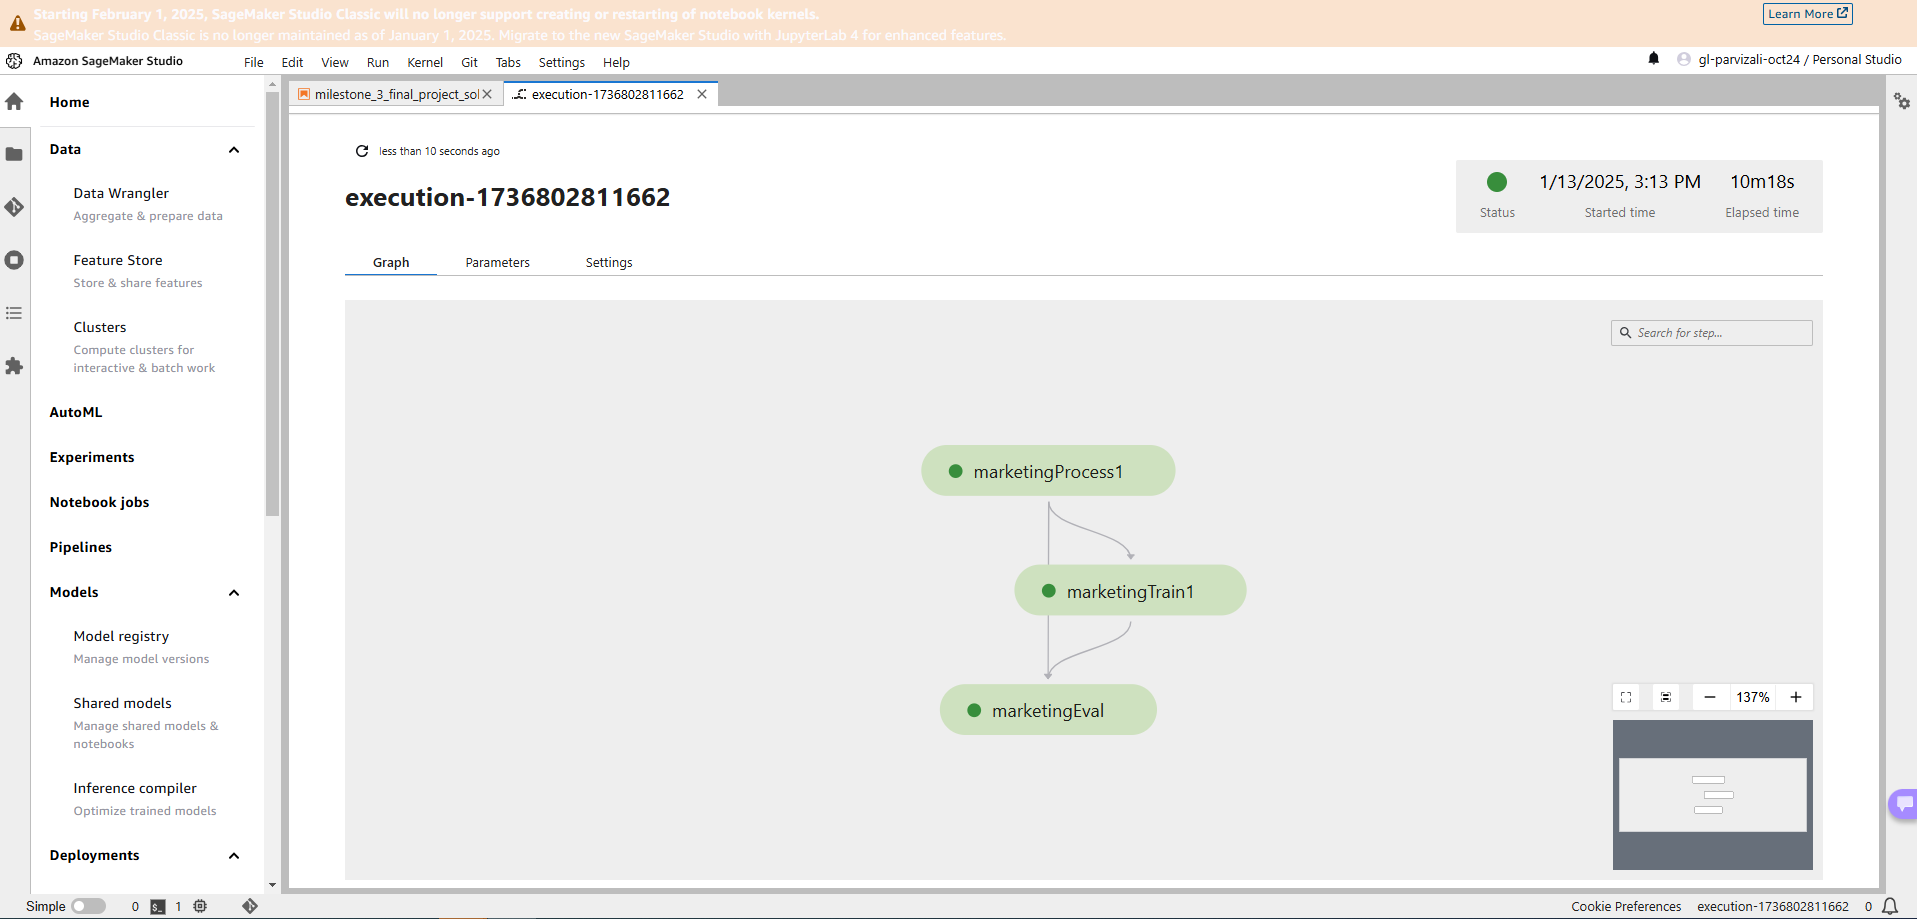

In [4]:
#Git added